In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import scipy.stats
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
df = pd.read_csv('./term-deposit-marketing-2020.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


# Data Description

> **Age:** Age of customer  
> **Job:** Type of job  
> **Marital:** Marital status   
> **Education:**  
> **Default:** Has credit in default?  
> **Balance:** Average yearly balance, in euros  
> **Housing:** Has a housing loan?  
> **Loan:** Has personal loan?  
> **Contact:** Contact communication type  
> **Day:** Last contact day of the month  
> **Month:** Last contact month of year  
> **Duration:** Last contact duration, in seconds  
> **Campaign:** Number of contacts performed during this campaign and for this client (includes last contact)  

# EDA

In [7]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [8]:
## descriptive statistics of customers who signed up for term deposits

df.loc[(df['y'] == 'yes')].describe()

,age,balance,day,duration,campaign
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000
mean,39.844959,1588.495856,15.827003,682.958564,2.414365
std,11.001984,2924.894429,8.557604,431.287174,2.306015
min,19.000000,-3058.000000,1.000000,8.000000,1.000000
25%,31.000000,141.000000,8.000000,364.000000,1.000000
50%,37.000000,620.000000,16.000000,629.000000,2.000000
75%,47.000000,1820.500000,22.000000,913.000000,3.000000
max,95.000000,45248.000000,31.000000,3881.000000,32.000000


In [9]:
## descriptive statistics of customers who did not sign up for term deposits

df.loc[(df['y'] == 'no')].describe()

,age,balance,day,duration,campaign
count,37104.000000,37104.000000,37104.000000,37104.000000,37104.000000
mean,40.599208,1249.752533,16.032072,221.408042,2.918688
std,9.525450,2900.722436,8.255850,206.360022,3.298031
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,50.000000,8.000000,95.000000,1.000000
50%,39.000000,395.000000,17.000000,164.000000,2.000000
75%,48.000000,1286.000000,21.000000,280.000000,3.000000
max,94.000000,102127.000000,31.000000,4918.000000,63.000000


Taking a look at the difference in customers who sign up for a term deposit and those that don't, the only continuous feature that has a noticeable difference is the duration of the phone call. The customers who sign up are on the phone much longer than those that are not interested with the average duration being 11 minutes for customers who sign up and ~4 minutes for those who don't. The average yearly balance for those who sign up is also slightly higher than those who don't but the difference is not very significant.

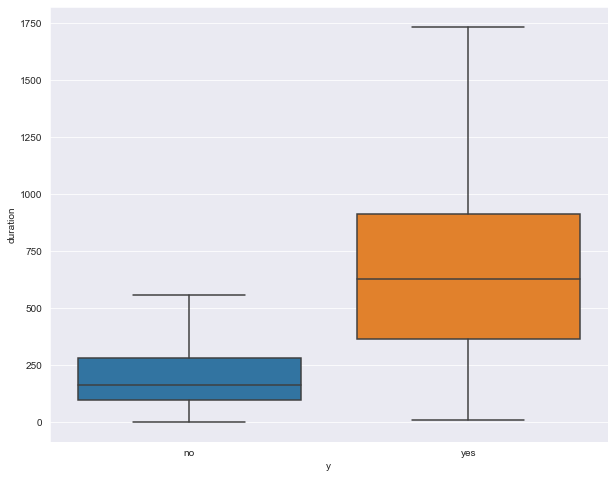

In [10]:
## graph the difference in duration to see the discrepancy more easily

plt.figure(figsize=(10, 8))
sns.boxplot(x='y', y='duration', data=df, showfliers=False)
plt.show()

Looking at this graph it is easy to see how much longer a customer that is interested will stay on the call. Most calls with customers that sign up for a term deposit are 

In [3]:
## replace binary categorical columns with 0s and 1s

cat_columns = ['default', 'housing', 'loan', 'y']

for name in cat_columns:
    df[name].replace(to_replace={'yes':1, 'no':0}, inplace=True)

In [12]:
df.corr()

,age,default,balance,housing,loan,day,duration,campaign,y
age,1.000000,-0.014857,0.081517,-0.179606,0.000041,-0.011689,-0.036270,0.016204,-0.020273
default,-0.014857,1.000000,-0.070069,-0.019229,0.075006,0.006287,-0.008597,0.012135,-0.006559
balance,0.081517,-0.070069,1.000000,-0.049946,-0.080596,0.011662,0.014072,-0.008137,0.030232
housing,-0.179606,-0.019229,-0.049946,1.000000,0.004266,-0.050622,0.022455,-0.054823,-0.054336
loan,0.000041,0.075006,-0.080596,0.004266,1.000000,0.005838,-0.003952,0.000582,-0.031029
day,-0.011689,0.006287,0.011662,-0.050622,0.005838,1.000000,-0.032983,0.165429,-0.006420
duration,-0.036270,-0.008597,0.014072,0.022455,-0.003952,-0.032983,1.000000,-0.088387,0.461169
campaign,0.016204,0.012135,-0.008137,-0.054823,0.000582,0.165429,-0.088387,1.000000,-0.040350
y,-0.020273,-0.006559,0.030232,-0.054336,-0.031029,-0.006420,0.461169,-0.040350,1.000000


Looking at the correlation matrix, it looks like duration of the phone call is the biggest predictor of whether or not a customer will sign up for a term deposit with a 46% correlation.

In [13]:
## number of customers who sign up split by education level

df.groupby(['education'])['y'].sum()

education
primary       353
secondary    1418
tertiary     1029
unknown        96
Name: y, dtype: int64

In [14]:
## percentage of customers who sign up split by education level

df.groupby(['education'])['y'].sum()/df.groupby(['education'])['y'].count()

education
primary      0.056300
secondary    0.067546
tertiary     0.091826
unknown      0.062704
Name: y, dtype: float64

Customers with a tertiary education sign up the most with a sign up rate of 9.2%. This is about a 2.4% increase from customers with secondary education who have a sign up rate of 6.8%.

# Data Preparation

In [15]:
## check for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  int64 
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  int64 
 7   loan       40000 non-null  int64 
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 4.3+ MB


In [16]:
df['job'].value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [17]:
df['education'].value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [18]:
df['contact'].value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

Even though there are no null values in the dataset, there are 'unknown' values in the job, education, and contact columns. Most of the unknown values are a small part of the column other than contact. Let's take a look and see if there is any way to fill in the unknown values.

In [19]:
print(f'Number of yes for cellular: {len(df.loc[(df["y"] == 1) & (df["contact"] == "cellular")])}')
print(f'Number of no for cellular: {len(df.loc[(df["y"] == 0) & (df["contact"] == "cellular")])}')
print(f'Ratio of yes to no for cellular: {len(df.loc[(df["y"] == 1) & (df["contact"] == "cellular")])/len(df.loc[(df["y"] == 0) & (df["contact"] == "cellular")])}\n')

print(f'Number of yes for telephone: {len(df.loc[(df["y"] == 1) & (df["contact"] == "telephone")])}')
print(f'Number of no for telephone: {len(df.loc[(df["y"] == 0) & (df["contact"] == "telephone")])}')
print(f'Ratio of yes to no for telephone: {len(df.loc[(df["y"] == 1) & (df["contact"] == "telephone")])/len(df.loc[(df["y"] == 0) & (df["contact"] == "telephone")])}\n')

print(f'Number of yes for unknown: {len(df.loc[(df["y"] == 1) & (df["contact"] == "unknown")])}')
print(f'Number of no for unknown: {len(df.loc[(df["y"] == 0) & (df["contact"] == "unknown")])}')
print(f'Ratio of yes to no for unknown: {len(df.loc[(df["y"] == 1) & (df["contact"] == "unknown")])/len(df.loc[(df["y"] == 0) & (df["contact"] == "unknown")])}\n')

Number of yes for cellular: 2233
Number of no for cellular: 22681
Ratio of yes to no for cellular: 0.0984524491865438

Number of yes for telephone: 166
Number of no for telephone: 2155
Ratio of yes to no for telephone: 0.07703016241299304

Number of yes for unknown: 497
Number of no for unknown: 12268
Ratio of yes to no for unknown: 0.0405119008803391



Looking at the ratios of yes's and no's between methods of contact, all the ratios are pretty similar suggesting that the method of communication does not influence whether or not a customer will sign up for a term deposit. Because of this, I'll leave the unknown values as is.

In [20]:
## only 7% of people sign up for a term deposit

df['y'].value_counts(normalize=True)

0    0.9276
1    0.0724
Name: y, dtype: float64

In [16]:
X = df.drop(labels=['y'], axis=1)
y = df['y']

In [5]:
## drop the day and month columns because they are unnecessary

X.drop(['day', 'month'], axis=1, inplace=True)

In [11]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign
0,58,management,married,tertiary,0,2143,1,0,unknown,261,1
1,44,technician,single,secondary,0,29,1,0,unknown,151,1
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,76,1
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,92,1
4,33,unknown,single,unknown,0,1,0,0,unknown,198,1


In [24]:
## create dummies for categorical variables except for job because job has too many unique values

marital_dummies = pd.get_dummies(X['marital'], drop_first=True)
education_dummies = pd.get_dummies(X['education'], prefix='education', drop_first=True)
contact_dummies = pd.get_dummies(X['contact'], prefix='contact', drop_first=True)

X_dummies = pd.concat([X.drop(['marital', 'education', 'contact'], axis=1), 
                       marital_dummies, education_dummies, contact_dummies], axis=1)
X_dummies.head()

,age,job,default,balance,housing,loan,duration,campaign,married,single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown
0,58,management,0,2143,1,0,261,1,1,0,0,1,0,0,1
1,44,technician,0,29,1,0,151,1,0,1,1,0,0,0,1
2,33,entrepreneur,0,2,1,1,76,1,1,0,1,0,0,0,1
3,47,blue-collar,0,1506,1,0,92,1,1,0,0,0,1,0,1
4,33,unknown,0,1,0,0,198,1,0,1,0,0,1,0,1


In [25]:
## use label encoder on job

labelencoder = LabelEncoder()
X_dummies['job'] = labelencoder.fit_transform(X_dummies['job'])

In [26]:
X_dummies.head()

,age,job,default,balance,housing,loan,duration,campaign,married,single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown
0,58,4,0,2143,1,0,261,1,1,0,0,1,0,0,1
1,44,9,0,29,1,0,151,1,0,1,1,0,0,0,1
2,33,2,0,2,1,1,76,1,1,0,1,0,0,0,1
3,47,1,0,1506,1,0,92,1,1,0,0,0,1,0,1
4,33,11,0,1,0,0,198,1,0,1,0,0,1,0,1


# Modeling

Now that the data has been taken care of let's run it through some models.

In [61]:
## split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

# Logistic Regression

In [46]:
## create a logistic regression model

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

## find out accuracy score

y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.933
Testing Accuracy:  0.9334166666666667


In [47]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_val_score(logreg, X_dummies, y, scoring='accuracy', cv=cv)

print('Accuracy: {}'.format(np.mean(scores)))

Accuracy: 0.933425


A standard logistic regression model performs extremely well with a training accuracy of 93% and a testing acuracy of 93%. Let's see if we can improve upon the performance by tuning the hyperparameters.

In [48]:
## run all features through a logistic regression model
## create grid parameter for logistic regression
logreg = LogisticRegression(solver='liblinear')
logistic_grid = [{'C': [1, 50, 2000, 1e15],
                  'penalty': ['l1', 'l2']}]

te_log_gridsearch = GridSearchCV(estimator=logreg,
                                   param_grid=logistic_grid,
                                   scoring='accuracy',
                                   cv=5)

te_log_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid=[{'C': [1, 50, 2000, 1000000000000000.0],
                          'penalty': ['l1', 'l2']}],
             scoring='accuracy')

In [49]:
## find out accuracy score

y_hat_train = te_log_gridsearch.predict(X_train)
y_hat_test = te_log_gridsearch.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9327857142857143
Testing Accuracy:  0.933


Performance stays the same after tuning hyperparameters with an accuracy score of 93%.

# Random Forest

In [50]:
## create a random forest model

rf = RandomForestClassifier(random_state=27)
rf.fit(X_train, y_train)
    
## find out accuracy score
    
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  1.0
Testing Accuracy:  0.9318333333333333


In [51]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_val_score(rf, X_dummies, y, scoring='accuracy', cv=cv)

print('Accuracy: {}'.format(np.mean(scores)))

Accuracy: 0.931775


The random forest model performs better on the training set with a 100% accuracy rate but performs similarly to the logistic regression model with a training accuracy of 93%

In [52]:
## define a function to plot imporant features

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

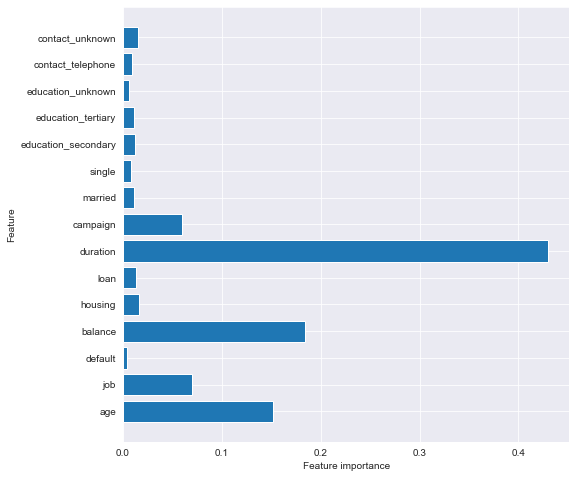

In [53]:
plot_feature_importances(rf)

The feature importance chart reinforces that the duration of the call is the most important feature in determining whether or not a customer will sign up for a term deposit. The second and third most important features are balance and age.

# LightGBM

In [54]:
## create lightGBM model

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

## find out accuracy score

y_hat_train = lgbm.predict(X_train)
y_hat_test = lgbm.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9486071428571429
Testing Accuracy:  0.9326666666666666


In [55]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_val_score(lgbm, X_dummies, y, scoring='accuracy', cv=cv)

print('Accuracy: {}'.format(np.mean(scores)))

Accuracy: 0.9317


The LightGBM model performs slightly worse on the training set with a 95% accuracy rate, but the testing accuracy stays the same as the other models at 93%.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

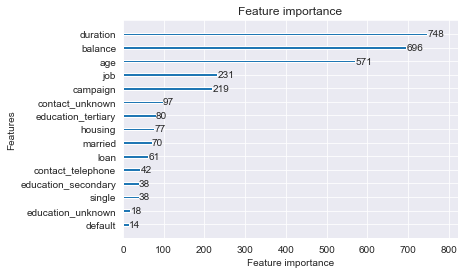

In [56]:
lgb.plot_importance(lgbm)

Just like the random forest model, the LightGBM model shows us that the most important features are duration of the call followed by balance and age.

In [102]:
## create grid parameter for LightGBM

lgbm = lgb.LGBMClassifier()
lgbm_grid = [{'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6, 9],
            'min_data_in_leaf': [10, 50, 100, 500]}]

lgbm_gridsearch = GridSearchCV(estimator=lgbm, 
                             param_grid=lgbm_grid,
                             scoring='accuracy',
                             cv=5)

lgbm_gridsearch.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid=[{'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 9],
                          'min_data_in_leaf': [10, 50, 100, 500]}],
             scoring='accuracy')

In [103]:
## find out accuracy score

y_hat_train = lgbm_gridsearch.predict(X_train)
y_hat_test = lgbm_gridsearch.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9350714285714286
Testing Accuracy:  0.9333333333333333


Tuning the hyperparameters does not improve model performance, lowering the training accuracy to 94% and the testing accuracy stays the same at 93%.

# XGBoost

In [57]:
## create an xgboost model

xgboost = XGBClassifier(use_label_encoder=False)
xgboost.fit(X_train, y_train)

## find out accuracy score

y_hat_train = xgboost.predict(X_train)
y_hat_test = xgboost.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

[23:24:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.9629642857142857
Testing Accuracy:  0.9306666666666666


In [58]:
cv = KFold(n_splits=5, random_state=10, shuffle=True)
scores = cross_val_score(xgboost, X_dummies, y, scoring='accuracy', cv=cv)

print('Accuracy: {}'.format(np.mean(scores)))

[23:24:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Just like all the previous models, XGBoost performs very similarly with a training accurayc of 96% and a testing accuracy of 93%.

In [18]:
## create grid parameter for random forest

xgboost = XGBClassifier(use_label_encoder=False)
xgb_grid = [{'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6, 9],
            'min_child_weight': [5, 10, 20],
            'subsample': [0.3, 0.7],
            'n_estimators': [5, 30, 100, 250]}]

xgb_gridsearch = GridSearchCV(estimator=xgboost, 
                             param_grid=xgb_grid,
                             scoring='accuracy',
                             cv=5)

xgb_gridsearch.fit(X_train, y_train)

[03:13:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:13:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:13:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:13:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:13:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:14:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:14:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:15:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:15:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:15:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:15:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:16:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:16:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:17:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:17:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:17:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:17:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:17:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:18:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:18:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:18:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:18:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:18:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:18:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:18:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:18:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:18:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:19:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:19:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:19:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:20:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:20:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[03:20:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:20:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_

In [19]:
## find out accuracy score

y_hat_train = xgb_gridsearch.predict(X_train)
y_hat_test = xgb_gridsearch.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9347142857142857
Testing Accuracy:  0.9346666666666666


Tuning the hyperparameters for xgboost improves the testing accuracy to 93.5% which is a tiny improvement when compared to the other models by ~0.2%.

In [20]:
xgb_gridsearch.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 250,
 'subsample': 0.7}

In [21]:
optimal_xgb = XGBClassifier(use_label_encoder=False,
                            learning_rate=0.01,
                            max_depth=3,
                            min_child_weight=5,
                            n_estimators=250,
                            subsample=0.7)

optimal_xgb.fit(X_train, y_train)

## find out accuracy score

y_hat_train = optimal_xgb.predict(X_train)
y_hat_test = optimal_xgb.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

[03:26:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.9347142857142857
Testing Accuracy:  0.9346666666666666


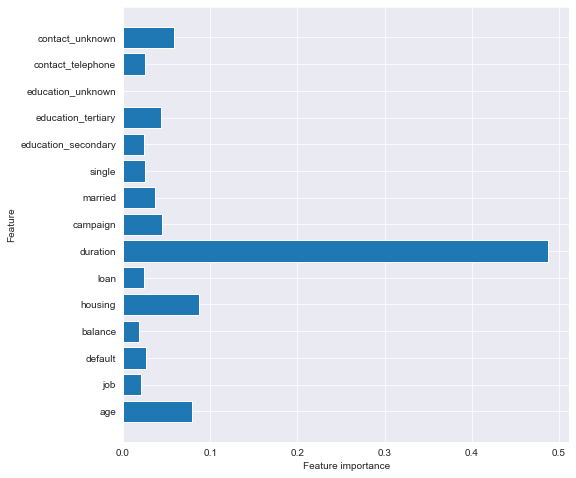

In [23]:
plot_feature_importances(optimal_xgb)

Duration is once again the most important feature with the optimal xgboost model, however the second most important feature in this model is housing. Like the other models, the third most important feature is age.

# Conclusion

After running the data through various models, the best performing model is xgboost with a training and testing accuracy of 93.5%. The model has an extremely high accuracy rate and I would be confident in the model to predict whether or not a future customer will be interested in the marketing campaigns products.

The most predictive factor in whether or not a customer will sign up for a term deposit is the duration of the phone call. The average duration of a phone call for customers who sign up for a term deposit is 11 minutes while the average duration for customers who are not interested is 3-4 minutes. If the campaign is able to engage the customer past the 4 minute mark and keep them interested in the product the success rate for sales should increase. 

The subsets of customers to focus on to maximize sign ups are customers with a tertiary education. These customers sign up about 9% of the time where as customers with a secondary education only sign up about 7% of the time.

# Appendix

I will try to determine a subset of customers that are more likely to sign up for a term deposit.

In [82]:
## create a groupby object separating customers by job and education to find their average call duration

group = df.groupby(['job', 'education']).agg(avg_duration=('duration', 'mean'))
group.reset_index(inplace=True)

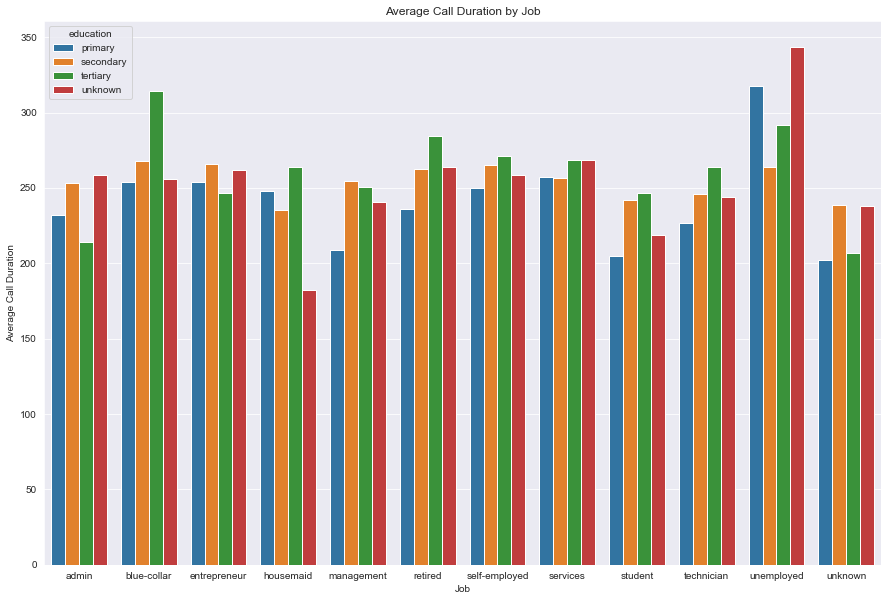

In [24]:
plt.figure(figsize=(15, 10))
sns.barplot(x='job', y='avg_duration', hue='education', data=group)
plt.xlabel('Job')
plt.ylabel('Average Call Duration')
plt.title('Average Call Duration by Job')
plt.show()

We know that call duration is the most important factor in determining whether or not a customer will sign up for a term deposit. Taking a look at this graph, it seems like blue collar workers with a tertiary education and unemployed customers with an unknown or primary education have the longest average call durations. 

In [54]:
## create a groupby object separating customers by job and marital status to find their average call duration

group = df.groupby(['job', 'marital']).agg(avg_duration=('duration', 'mean'))
group.reset_index(inplace=True)

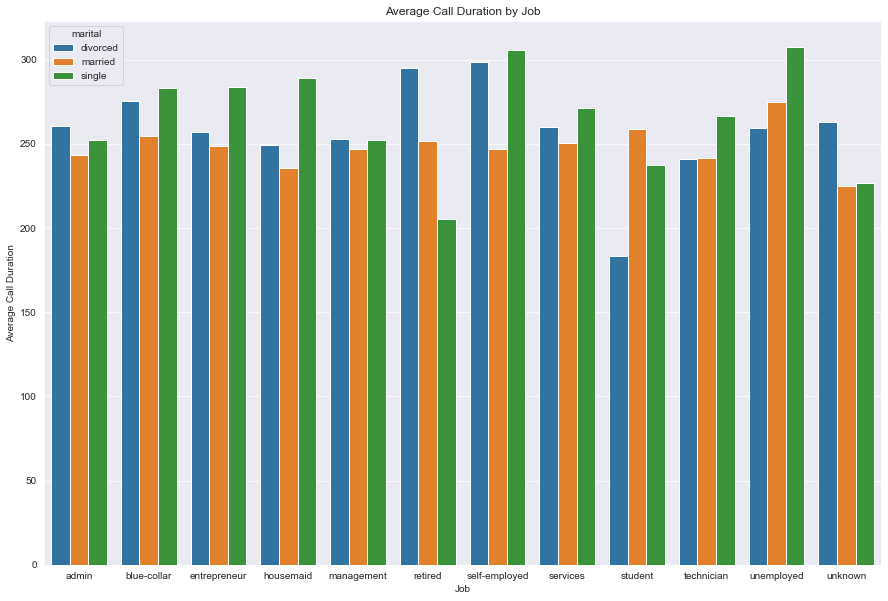

In [55]:
plt.figure(figsize=(15, 10))
sns.barplot(x='job', y='avg_duration', hue='marital', data=group)
plt.xlabel('Job')
plt.ylabel('Average Call Duration')
plt.title('Average Call Duration by Job')
plt.show()

The marriage status of customers does not seem to affect call duration that much. The biggest difference is retired divorced customers seems to have a much longer average call duration than their married and single counterparts. Single unemployed customers and single self employed customers also the longest average call duration.

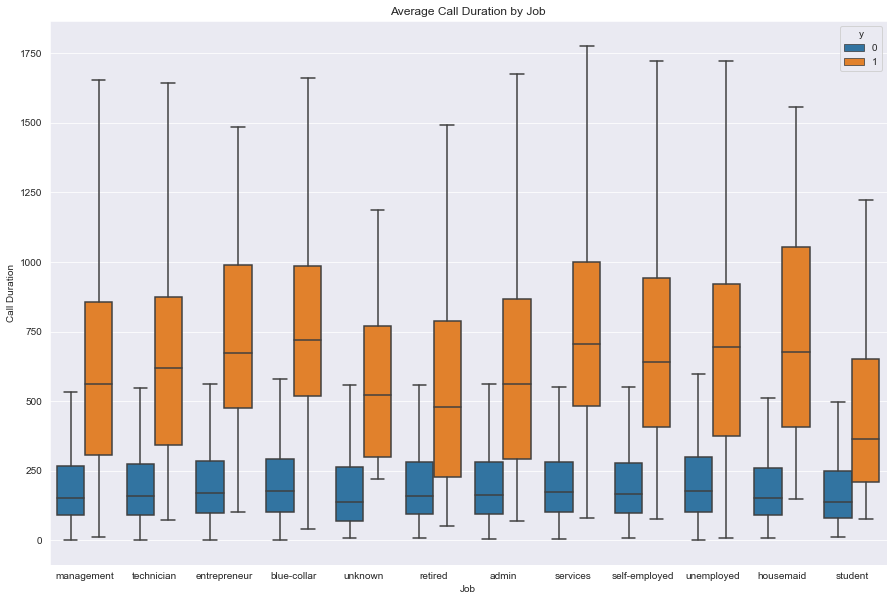

In [29]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='job', y='duration', hue='y', data=df, showfliers=False)
plt.xlabel('Job')
plt.ylabel('Call Duration')
plt.title('Average Call Duration by Job')
plt.show()

In [77]:
## number of customers who signed up grouped by job

df.groupby(['job'])['y'].sum()

job
admin            351
blue-collar      535
entrepreneur      88
housemaid         53
management       676
retired          151
self-employed    112
services         238
student           82
technician       497
unemployed        96
unknown           17
Name: y, dtype: int64

In [78]:
## number of customers who did not sign up grouped by job

df.groupby(['job'])['y'].count() - df.groupby(['job'])['y'].sum()

job
admin            4132
blue-collar      8848
entrepreneur     1317
housemaid        1034
management       7490
retired          1286
self-employed    1302
services         3672
student           442
technician       6355
unemployed       1008
unknown           218
Name: y, dtype: int64

In [79]:
## percentage of customers who signed up grouped by job

df.groupby(['job'])['y'].sum()/df.groupby(['job'])['y'].count()

job
admin            0.078296
blue-collar      0.057018
entrepreneur     0.062633
housemaid        0.048758
management       0.082782
retired          0.105080
self-employed    0.079208
services         0.060870
student          0.156489
technician       0.072534
unemployed       0.086957
unknown          0.072340
Name: y, dtype: float64

Students are the most likely to sign up for a term deposit with a 15.6% sign up rate followed by retired customers with a 10.5% sign up rate. The rest of the jobs all hover around a 6-9% sign up rate. The least likely to sign up for a term deposit are housemaids with a 4.9% sign up rate. The high sign up rate for students could be explained by the low total number of student customers when compared to the other jobs. If there were more student customers, their sign up rate could fall to the sign up rate of the other jobs.

I will run a chi square test to determine if the high sign up rate for students is statistically significant.

In [30]:
## run a chi square test on the job categorical variable

ct1 = pd.crosstab(df['y'], df['job'])
print(ct1)

colsum = ct1.sum(axis=0)
colpct = ct1/colsum
print(colpct)

job  admin  blue-collar  entrepreneur  housemaid  management  retired  \
y                                                                       
0     4132         8848          1317       1034        7490     1286   
1      351          535            88         53         676      151   

job  self-employed  services  student  technician  unemployed  unknown  
y                                                                       
0             1302      3672      442        6355        1008      218  
1              112       238       82         497          96       17  
job     admin  blue-collar  entrepreneur  housemaid  management  retired  \
y                                                                          
0    0.921704     0.942982      0.937367   0.951242    0.917218  0.89492   
1    0.078296     0.057018      0.062633   0.048758    0.082782  0.10508   

job  self-employed  services   student  technician  unemployed  unknown  
y                                   

In [31]:
print('chi-square value, p value, expected counts')
cs1 = scipy.stats.chi2_contingency(ct1)
cs1

chi-square value, p value, expected counts


(149.75042154316787,
 1.6761348063575326e-26,
 11,
 array([[4158.4308, 8703.6708, 1303.278 , 1008.3012, 7574.7816, 1332.9612,
         1311.6264, 3626.916 ,  486.0624, 6355.9152, 1024.0704,  217.986 ],
        [ 324.5692,  679.3292,  101.722 ,   78.6988,  591.2184,  104.0388,
          102.3736,  283.084 ,   37.9376,  496.0848,   79.9296,   17.014 ]]))

P value is much lower than 0.05 so we reject the null hypothesis that the sign up rate between jobs is equal.

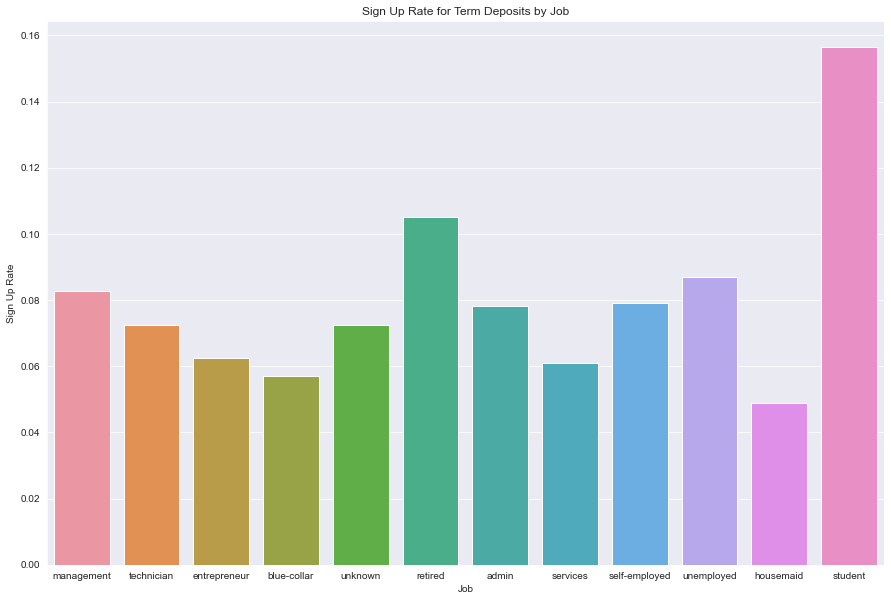

In [64]:
plt.figure(figsize=(15, 10))
sns.barplot(x='job', y='y', data=df, ci=None)
plt.xlabel('Job')
plt.ylabel('Sign Up Rate')
plt.title('Sign Up Rate for Term Deposits by Job')
plt.show()

Looking at this graph, students seem to be the most likely group to sign up for a term deposit followed by retired customers. Let's see if the difference between groups is statistically significant.

In [28]:
## use tukey test to determine which jobs have a statistically significant difference of means

from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df['y'], groups=df['job'], alpha=0.05)
print(m_comp)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
        admin   blue-collar  -0.0213  0.001 -0.0366 -0.0059   True
        admin  entrepreneur  -0.0157 0.6806 -0.0415  0.0102  False
        admin     housemaid  -0.0295 0.0355 -0.0581  -0.001   True
        admin    management   0.0045    0.9 -0.0112  0.0202  False
        admin       retired   0.0268 0.0313  0.0012  0.0524   True
        admin self-employed   0.0009    0.9 -0.0249  0.0267  False
        admin      services  -0.0174 0.0875 -0.0359  0.0011  False
        admin       student   0.0782  0.001  0.0392  0.1172   True
        admin    technician  -0.0058    0.9  -0.022  0.0105  False
        admin    unemployed   0.0087    0.9 -0.0197  0.0371  False
        admin       unknown   -0.006    0.9 -0.0625  0.0506  False
  blue-collar  entrepreneur   0.0056    0.9 -0.0186  0.0298  F

The mean sign up rate for students is significantly different from all other jobs so we can conclude that students are the most likely to sign up for a term deposit.

In [53]:
## chi square test for education

ct2 = pd.crosstab(df['y'], df['education'])
print(ct2)

colsum = ct2.sum(axis=0)
colpct = ct2/colsum
print(colpct)

education  primary  secondary  tertiary  unknown
y                                               
0             5917      19575     10177     1435
1              353       1418      1029       96
education  primary  secondary  tertiary   unknown
y                                                
0           0.9437   0.932454  0.908174  0.937296
1           0.0563   0.067546  0.091826  0.062704


In [54]:
print('chi-square value, p value, expected counts')
cs2 = scipy.stats.chi2_contingency(ct2)
cs2

chi-square value, p value, expected counts


(96.67441494404032,
 8.06191084544081e-21,
 3,
 array([[ 5816.052 , 19473.1068, 10394.6856,  1420.1556],
        [  453.948 ,  1519.8932,   811.3144,   110.8444]]))

P value is much less than 0.05 allowing us to reject the null hypothesis that the sign up rate between education levels is equal.

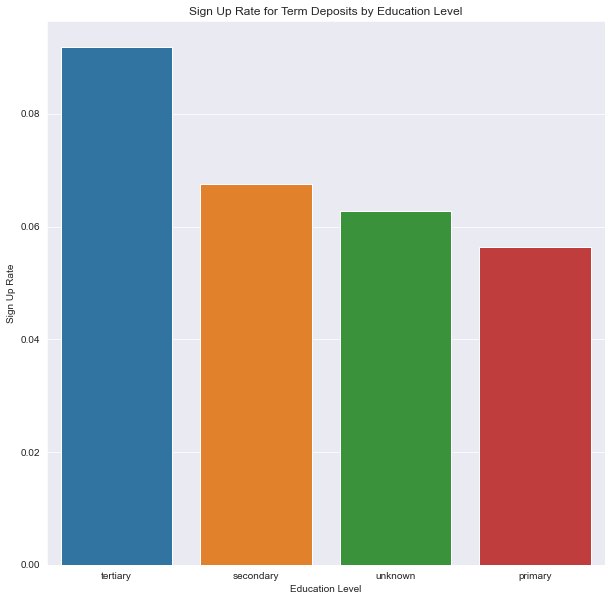

In [66]:
plt.figure(figsize=(10, 10))
sns.barplot(x='education', y='y', data=df, ci=None)
plt.xlabel('Education Level')
plt.ylabel('Sign Up Rate')
plt.title('Sign Up Rate for Term Deposits by Education Level')
plt.show()

In [34]:
m_comp = pairwise_tukeyhsd(endog=df['y'], groups=df['education'], alpha=0.05)
print(m_comp)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  primary secondary   0.0112 0.0135  0.0017 0.0208   True
  primary  tertiary   0.0355  0.001   0.025  0.046   True
  primary   unknown   0.0064  0.798 -0.0126 0.0254  False
secondary  tertiary   0.0243  0.001  0.0165 0.0321   True
secondary   unknown  -0.0048 0.8885 -0.0224 0.0128  False
 tertiary   unknown  -0.0291  0.001 -0.0472 -0.011   True
---------------------------------------------------------


Customers with a tertiary education are the most likely to sign up for a term deposit with their mean sign up rate being significantly different from all other education levels.

In [56]:
## chi square test for marital status

ct3 = pd.crosstab(df['y'], df['marital'])
print(ct3)

colsum = ct3.sum(axis=0)
colpct = ct3/colsum
print(colpct)

marital  divorced  married  single
y                                 
0            4334    22908    9862
1             391     1478    1027
marital  divorced   married    single
y                                    
0        0.917249  0.939391  0.905685
1        0.082751  0.060609  0.094315


In [57]:
print('chi-square value, p value, expected counts')
cs3 = scipy.stats.chi2_contingency(ct3)
cs3

chi-square value, p value, expected counts


(135.89809645322464,
 3.091030601234065e-30,
 2,
 array([[ 4382.91  , 22620.4536, 10100.6364],
        [  342.09  ,  1765.5464,   788.3636]]))

With a p value lower than 0.05, we reject the null hypothesis that the sign up rate is equal amongst all marital groups.

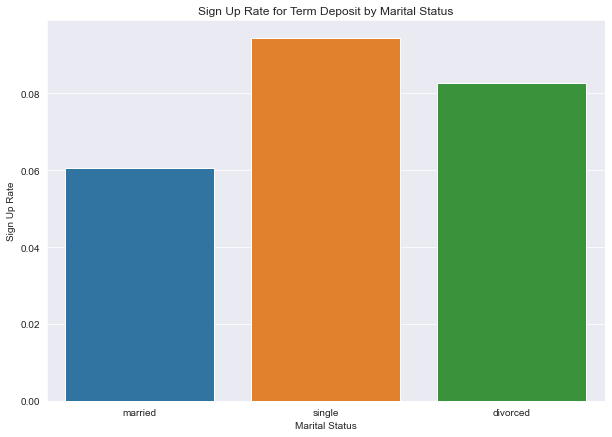

In [69]:
plt.figure(figsize=(10, 7))
sns.barplot(x='marital', y='y', data=df, ci=None)
plt.xlabel('Marital Status')
plt.ylabel('Sign Up Rate')
plt.title('Sign Up Rate for Term Deposit by Marital Status')
plt.show()

In [59]:
m_comp = pairwise_tukeyhsd(endog=df['y'], groups=df['marital'], alpha=0.05)
print(m_comp)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
divorced married  -0.0221  0.001 -0.0318 -0.0125   True
divorced  single   0.0116 0.0278   0.001  0.0221   True
 married  single   0.0337  0.001  0.0267  0.0407   True
-------------------------------------------------------


While all the groups are significantly different from one another, single customers are the most likely to sign up for a term deposit with divorced customers being the second most likely to sign up. Married customers are the least likely to sign up for a term deposit.

In [74]:
## number of customers who signed up grouped by job and education

df.groupby(['job', 'education'])['y'].sum().unstack()

education,primary,secondary,tertiary,unknown
job,,,,
admin,9,287,49,6
blue-collar,181,313,15,26
entrepreneur,10,35,37,6
housemaid,27,14,10,2
management,11,70,581,14
retired,51,56,39,5
self-employed,4,35,71,2
services,23,196,8,11
student,5,43,26,8


In [75]:
## number of customers who did not sign up grouped by job and education

df.groupby(['job', 'education'])['y'].count().unstack() - df.groupby(['job', 'education'])['y'].sum().unstack()

education,primary,secondary,tertiary,unknown
job,,,,
admin,193,3436,361,142
blue-collar,3492,4831,112,413
entrepreneur,166,472,611,68
housemaid,528,331,137,38
management,262,967,6086,175
retired,434,608,190,54
self-employed,125,517,631,29
services,313,3073,162,124
student,13,239,124,66


In [76]:
## percentage of customers who signed up grouped by job and education

df.groupby(['job', 'education'])['y'].sum().unstack()/df.groupby(['job', 'education'])['y'].count().unstack()

education,primary,secondary,tertiary,unknown
job,,,,
admin,0.044554,0.077088,0.119512,0.040541
blue-collar,0.049279,0.060848,0.118110,0.059226
entrepreneur,0.056818,0.069034,0.057099,0.081081
housemaid,0.048649,0.040580,0.068027,0.050000
management,0.040293,0.067502,0.087146,0.074074
retired,0.105155,0.084337,0.170306,0.084746
self-employed,0.031008,0.063406,0.101140,0.064516
services,0.068452,0.059957,0.047059,0.081481
student,0.277778,0.152482,0.173333,0.108108


The subsets of customers to focus on to maximize sign ups are customers in administration with a tertiary education, these customers are 4% more likely to sign up than customers in administration with lower education. Also, blue collar workers with a tertiary education, who are 6% more likely to sign up than their counterparts. 

In [12]:
test = df.drop(labels=['default', 'contact', 'campaign', 'duration', 'day', 'month', 'y'], axis=1)
test

,age,job,marital,education,balance,housing,loan
0,58,management,married,tertiary,2143,1,0
1,44,technician,single,secondary,29,1,0
2,33,entrepreneur,married,secondary,2,1,1
3,47,blue-collar,married,unknown,1506,1,0
4,33,unknown,single,unknown,1,0,0
...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,395,0,0
39996,30,management,single,tertiary,3340,0,0
39997,54,admin,divorced,secondary,200,0,0
39998,34,management,married,tertiary,1047,0,0


In [13]:
labelencoder = LabelEncoder()
test['job'] = labelencoder.fit_transform(test['job'])
test['marital'] = labelencoder.fit_transform(test['marital'])
test['education'] = labelencoder.fit_transform(test['education'])

In [14]:
test

,age,job,marital,education,balance,housing,loan
0,58,4,1,2,2143,1,0
1,44,9,2,1,29,1,0
2,33,2,1,1,2,1,1
3,47,1,1,3,1506,1,0
4,33,11,2,3,1,0,0
...,...,...,...,...,...,...,...
39995,53,9,1,2,395,0,0
39996,30,4,2,2,3340,0,0
39997,54,0,0,1,200,0,0
39998,34,4,1,2,1047,0,0


In [17]:
## split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.3, random_state=42)

In [18]:
classifier = lgb.LGBMClassifier(categorical_feature=[1, 2, 3, 5, 6])
classifier.fit(X_train, y_train)

C:\Users\Chris\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


LGBMClassifier(categorical_feature=[1, 2, 3, 5, 6])

In [19]:
## find out accuracy score

y_hat_train = classifier.predict(X_train)
y_hat_test = classifier.predict(X_test)

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Training Accuracy:  0.9295714285714286
Testing Accuracy:  0.9268333333333333


<AxesSubplot:>

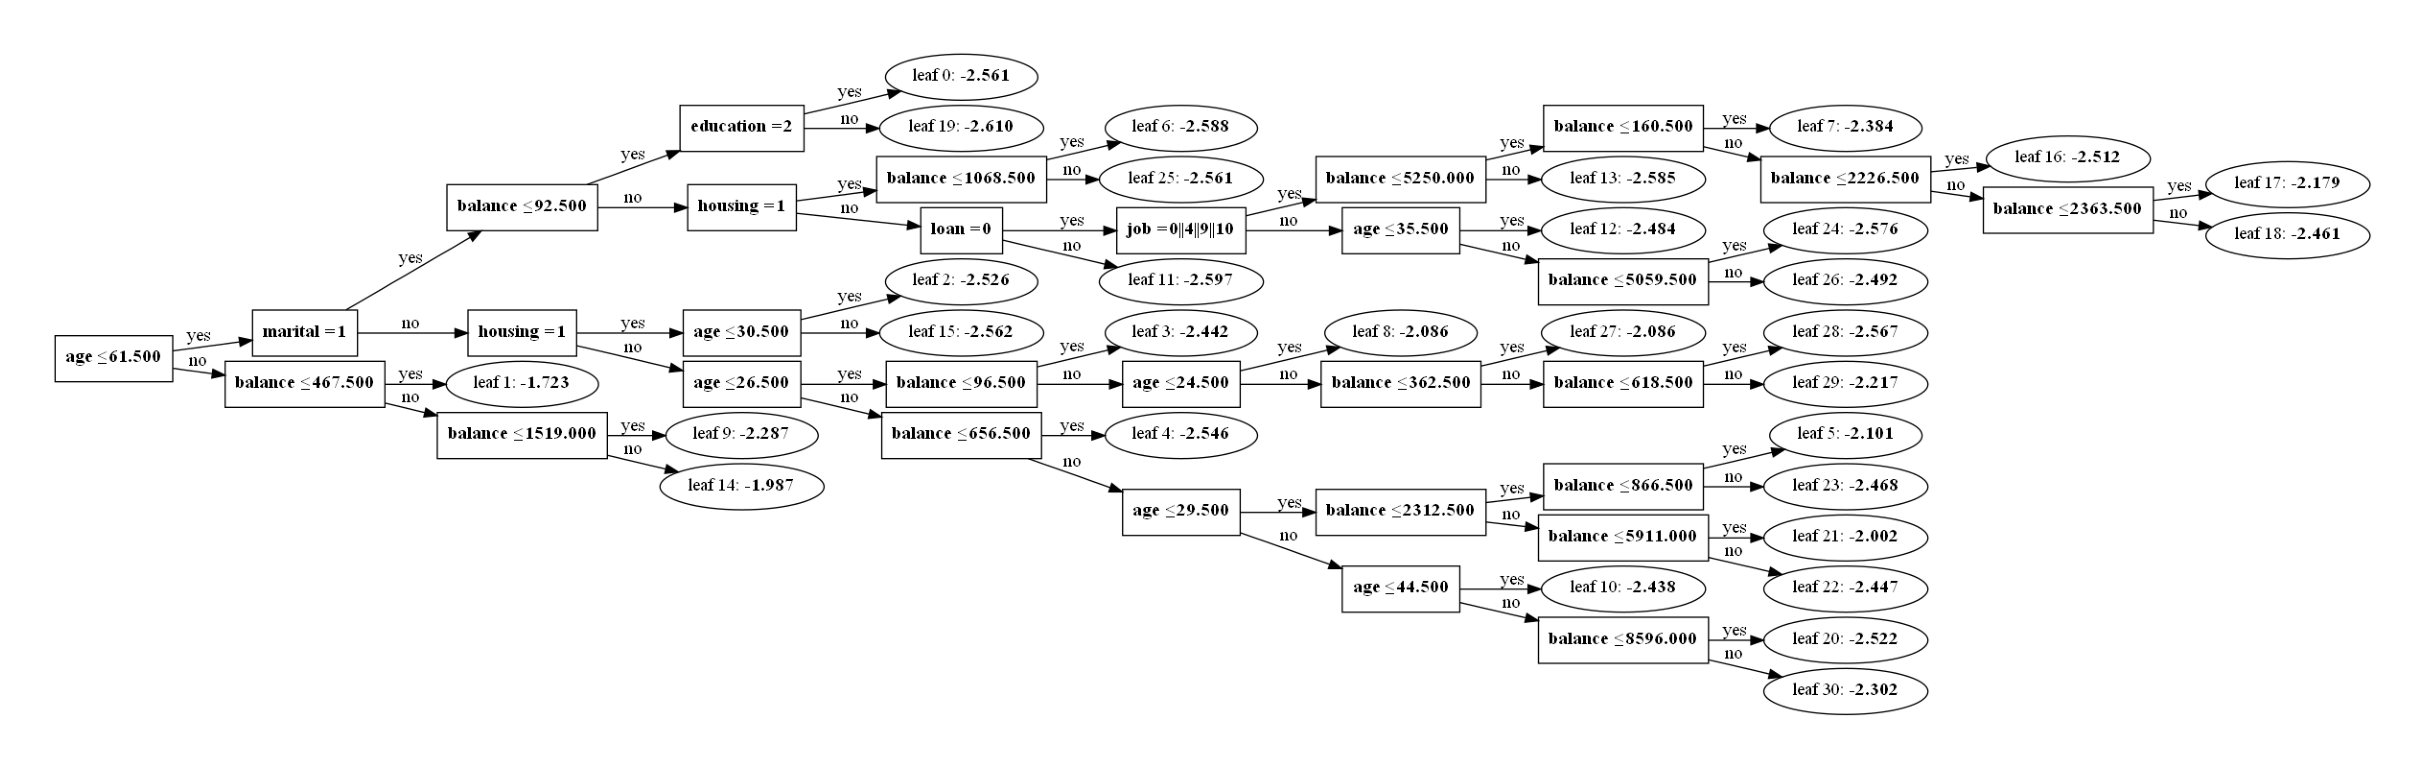

In [20]:
lgb.plot_tree(classifier, dpi=500, tree_index=0)